# Trend Cloud Analysis with Softmax (LOG SCALE)
## Advanced Technical Analysis for Stock Market Convergence Detection

This notebook implements the trend cloud algorithm using **logarithmic scale** for better trend analysis:
1. **Data Collection**: Get 1 year of stock candle data
2. **Log Transformation**: Convert prices to log scale for percentage-based analysis
3. **Pivot Detection**: Find swing highs and lows on log scale
4. **Trendline Detection**: Find top 20 log-scale trendlines through most pivot points
5. **Projection**: Project log-scale trendlines 5 days ahead
6. **Convergence Detection**: Find where log-scale trendlines converge
7. **Binning**: Group convergences into price bins
8. **Softmax**: Apply softmax to emphasize strongest convergence zones
9. **Visualization**: Create trend clouds with log-scale plotting

**🔬 LOG SCALE ADVANTAGES:**
- Trendlines represent **constant percentage growth rates** (e.g., +5%/day)
- Better handling of exponential price movements
- More meaningful for long-term trend analysis
- Percentage-based distance calculations

In [15]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from scipy import stats
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings('ignore')

# Set up plotting with WHITE background
plt.style.use('default')  # Changed from 'dark_background' to white
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
sns.set_palette("husl")

print("📦 Libraries imported successfully with WHITE background theme!")

📦 Libraries imported successfully with WHITE background theme!


In [16]:
# Configuration
SYMBOL = 'QQQ'  # Change this to test different stocks: QQQ, AAPL, MSFT, GOOGL, TSLA
LOOKBACK_DAYS = 365  # 1 year of data
PROJECTION_DAYS = 5  # Project 5 days ahead
MAX_TRENDLINES = 30  # Top 20 trendlines
CONVERGENCE_THRESHOLD = 0.05  # 5% price threshold for convergence
TEMPERATURE = 2.0  # Softmax temperature

print(f"🎯 Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Lookback: {LOOKBACK_DAYS} days")
print(f"   Projection: {PROJECTION_DAYS} days ahead")
print(f"   Max trendlines: {MAX_TRENDLINES}")
print(f"   Convergence threshold: {CONVERGENCE_THRESHOLD*100}%")

🎯 Configuration:
   Symbol: QQQ
   Lookback: 365 days
   Projection: 5 days ahead
   Max trendlines: 30
   Convergence threshold: 5.0%


In [17]:
# Step 1: Load stock data from local database (filtered for regular trading hours) + LOG TRANSFORMATION
import sqlite3

def load_stock_data_from_db(symbol, days=365, timeframe='1D', filter_premarket=True):
    """Load stock data from the local SQLite database, filtering out premarket data"""
    db_path = 'data/stock-data.db'

    try:
        conn = sqlite3.connect(db_path)

        # Query with correct column names and timeframe case
        query = """
        SELECT timestamp, open, high, low, close, volume, adjusted_close
        FROM market_data
        WHERE symbol = ? AND timeframe = ?
        ORDER BY timestamp DESC
        LIMIT ?
        """

        print(f"📊 Loading {symbol} data from local database (timeframe: {timeframe})...")

        df = pd.read_sql_query(query, conn, params=(symbol, timeframe, days * 2))  # Get more data to filter
        conn.close()

        if df.empty:
            print(f"❌ No data found for {symbol} with timeframe {timeframe} in database")
            # Try alternative timeframe cases
            for alt_timeframe in ['1d', '1D', 'daily', 'DAILY']:
                if alt_timeframe != timeframe:
                    print(f"🔄 Trying alternative timeframe: {alt_timeframe}")
                    conn = sqlite3.connect(db_path)
                    df = pd.read_sql_query(query, conn, params=(symbol, alt_timeframe, days * 2))
                    conn.close()
                    if not df.empty:
                        print(f"✅ Found data with timeframe: {alt_timeframe}")
                        timeframe = alt_timeframe
                        break

            if df.empty:
                print(f"❌ No data found for {symbol} with any timeframe")
                return create_sample_data(symbol, days)

        # Convert timestamp and prepare data
        df['Date'] = pd.to_datetime(df['timestamp'], unit='s')
        df = df.rename(columns={
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'volume': 'Volume'
        })
        df['Price'] = df['Close']  # Use closing price as main price

        # Filter out premarket data if requested
        if filter_premarket:
            # Convert to Eastern Time (market timezone)
            df['DateTime_ET'] = df['Date'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
            df['Hour'] = df['DateTime_ET'].dt.hour
            df['Minute'] = df['DateTime_ET'].dt.minute

            print(f"📊 Before filtering: {len(df)} candles")
            print(f"   Time range: {df['DateTime_ET'].min()} to {df['DateTime_ET'].max()}")

            # Show distribution of hours
            hour_counts = df['Hour'].value_counts().sort_index()
            print(f"📊 Hour distribution (ET): {dict(hour_counts.head(10))}")

            # Filter for regular trading hours (9:30 AM - 4:00 PM ET)
            # Keep only data where hour is between 9-16 (inclusive)
            # For 9 AM, only keep if minute >= 30
            # For 4 PM, only keep if minute == 0 (market close)
            regular_hours_mask = (
                ((df['Hour'] == 9) & (df['Minute'] >= 30)) |  # 9:30 AM onwards
                (df['Hour'].between(10, 15)) |                # 10 AM - 3:59 PM
                ((df['Hour'] == 16) & (df['Minute'] == 0))    # 4:00 PM market close
            )

            # Also filter for weekdays only (Monday=0 to Friday=4)
            df['DayOfWeek'] = df['DateTime_ET'].dt.dayofweek
            weekday_mask = df['DayOfWeek'] < 5

            # Combine filters
            trading_hours_mask = regular_hours_mask & weekday_mask

            df_filtered = df[trading_hours_mask].copy()

            print(f"📊 After filtering: {len(df_filtered)} candles (removed {len(df) - len(df_filtered)} premarket/afterhours)")

            if len(df_filtered) == 0:
                print(f"⚠️ No regular trading hours data found, using all data")
                df_filtered = df

            # Clean up temporary columns
            df_filtered = df_filtered.drop(['DateTime_ET', 'Hour', 'Minute', 'DayOfWeek'], axis=1, errors='ignore')
            df = df_filtered

        # Sort by date (oldest first) and limit to requested days
        df = df.sort_values('Date').reset_index(drop=True).tail(days)

        # 🔬 ADD LOG TRANSFORMATION FOR LOG SCALE ANALYSIS
        df['LogPrice'] = np.log(df['Price'])  # Natural log for percentage-based analysis

        print(f"✅ Final dataset: {len(df)} candles for {symbol}")
        print(f"   Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
        print(f"   Price range: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")
        print(f"   📈 LogPrice range: {df['LogPrice'].min():.4f} - {df['LogPrice'].max():.4f}")
        print(f"   Current price: ${df['Price'].iloc[-1]:.2f} (log: {df['LogPrice'].iloc[-1]:.4f})")

        return df

    except Exception as e:
        print(f"❌ Error loading from database: {e}")
        print(f"🔄 Creating sample data for demonstration...")
        return create_sample_data(symbol, days)

def create_sample_data(symbol, days=365):
    """Create realistic sample stock data for demonstration"""
    np.random.seed(hash(symbol) % 2**32)  # Seed based on symbol for consistency

    # Base parameters for different stocks
    stock_params = {
        'QQQ': {'start_price': 350, 'volatility': 0.02, 'trend': 0.0001},
        'AAPL': {'start_price': 175, 'volatility': 0.025, 'trend': 0.0002},
        'MSFT': {'start_price': 320, 'volatility': 0.022, 'trend': 0.0001},
        'GOOGL': {'start_price': 130, 'volatility': 0.028, 'trend': 0.0001},
        'TSLA': {'start_price': 250, 'volatility': 0.04, 'trend': -0.0001},
    }

    params = stock_params.get(symbol, {'start_price': 100, 'volatility': 0.025, 'trend': 0})

    # Generate dates for weekdays only during market hours
    end_date = datetime.now()
    dates = pd.date_range(start=end_date - timedelta(days=days*1.5), end=end_date, freq='D')
    # Filter to weekdays only
    dates = [d.replace(hour=16, minute=0) for d in dates if d.weekday() < 5]  # 4 PM market close
    dates = dates[-days:]  # Take only the requested number of days

    # Generate realistic price data using geometric Brownian motion
    price = params['start_price']
    prices = []

    for i, date in enumerate(dates):
        # Add trend and random walk
        daily_return = params['trend'] + np.random.normal(0, params['volatility'])
        price = price * (1 + daily_return)

        # Add some larger moves occasionally (news events)
        if np.random.random() < 0.05:  # 5% chance of bigger move
            price = price * (1 + np.random.normal(0, params['volatility'] * 3))

        prices.append(max(1, price))  # Ensure positive prices

    # Create OHLC data
    data = []
    for i, (date, close) in enumerate(zip(dates, prices)):
        # Create realistic OHLC from close price
        volatility = params['volatility'] * close
        open_price = close + np.random.normal(0, volatility * 0.5)
        high = max(open_price, close) + abs(np.random.normal(0, volatility * 0.3))
        low = min(open_price, close) - abs(np.random.normal(0, volatility * 0.3))

        data.append({
            'Date': date,
            'Open': round(max(1, open_price), 2),
            'High': round(max(1, high), 2),
            'Low': round(max(1, low), 2),
            'Close': round(max(1, close), 2),
            'Volume': int(np.random.normal(1000000, 200000)),
            'Price': round(max(1, close), 2)
        })

    df = pd.DataFrame(data)
    # 🔬 ADD LOG TRANSFORMATION FOR SAMPLE DATA TOO
    df['LogPrice'] = np.log(df['Price'])

    print(f"✅ Created sample data: {len(df)} candles for {symbol} (market hours only)")
    print(f"   Price range: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")
    print(f"   📈 LogPrice range: {df['LogPrice'].min():.4f} - {df['LogPrice'].max():.4f}")
    print(f"   Current price: ${df['Price'].iloc[-1]:.2f} (log: {df['LogPrice'].iloc[-1]:.4f})")

    return df

# Check what symbols and timeframes are available in database
def check_database_contents():
    """Check what data is available in the database"""
    try:
        conn = sqlite3.connect('data/stock-data.db')

        # Get available symbols and timeframes
        query = """
        SELECT symbol, timeframe, COUNT(*) as record_count,
               MIN(timestamp) as earliest, MAX(timestamp) as latest
        FROM market_data
        GROUP BY symbol, timeframe
        ORDER BY symbol, timeframe
        """

        df = pd.read_sql_query(query, conn)

        # Also check time distribution for QQQ to see the premarket issue
        time_query = """
        SELECT
            datetime(timestamp, 'unixepoch') as dt,
            strftime('%H', datetime(timestamp, 'unixepoch')) as hour,
            COUNT(*) as count
        FROM market_data
        WHERE symbol = 'QQQ' AND timeframe = '1D'
        GROUP BY hour
        ORDER BY hour
        LIMIT 24
        """

        time_df = pd.read_sql_query(time_query, conn)
        conn.close()

        # Convert timestamps to readable dates
        df['earliest_date'] = pd.to_datetime(df['earliest'], unit='s').dt.date
        df['latest_date'] = pd.to_datetime(df['latest'], unit='s').dt.date

        print("📋 Database Contents:")
        print(df[['symbol', 'timeframe', 'record_count', 'earliest_date', 'latest_date']].to_string(index=False))

        print(f"\n🕐 Time Distribution for QQQ (UTC hours):")
        if not time_df.empty:
            print(time_df.to_string(index=False))

        return df

    except Exception as e:
        print(f"❌ Error checking database: {e}")
        return None

# Check database contents first
database_info = check_database_contents()

# Load data from database with premarket filtering
stock_data = load_stock_data_from_db(SYMBOL, LOOKBACK_DAYS, timeframe='1D', filter_premarket=True)
stock_data.head()

📋 Database Contents:
symbol timeframe  record_count earliest_date latest_date
  AAPL        1D         14026    1980-12-08  2025-09-02
 GOOGL        1D          6612    2004-08-01  2025-09-02
  MSFT        1D         12414    1986-03-01  2025-09-02
   QQQ        1D          8330    1999-03-01  2025-09-02

🕐 Time Distribution for QQQ (UTC hours):
                 dt hour  count
1999-04-05 04:00:00   04   1045
1999-03-01 05:00:00   05    612
1999-04-05 13:30:00   13   4263
1999-03-10 14:30:00   14   2409
2025-09-02 20:00:01   20      1
📊 Loading QQQ data from local database (timeframe: 1D)...
📊 Before filtering: 730 candles
   Time range: 2023-05-16 09:30:00-04:00 to 2025-09-02 16:00:01-04:00
📊 Hour distribution (ET): {0: 143, 9: 578, 10: 8, 16: 1}
📊 After filtering: 587 candles (removed 143 premarket/afterhours)
✅ Final dataset: 365 candles for QQQ
   Date range: 2024-04-04 to 2025-09-02
   Price range: $414.65 - $580.34
   📈 LogPrice range: 6.0274 - 6.3636
   Current price: $565.62 (lo

,timestamp,Open,High,Low,Close,Volume,adjusted_close,Date,Price,LogPrice
222,1712237400,446.329987,446.950012,435.109985,435.339996,57267700,432.209747,2024-04-04 13:30:00,435.339996,6.076127
223,1712323800,436.779999,443.170013,435.959991,440.470001,54744600,437.302887,2024-04-05 13:30:00,440.470001,6.087842
224,1712583000,441.410004,442.500000,439.200012,440.600006,28144900,437.431946,2024-04-08 13:30:00,440.600006,6.088137
225,1712669400,442.959991,443.239990,437.440002,442.230011,39443600,439.050262,2024-04-09 13:30:00,442.230011,6.091830
226,1712755800,437.000000,439.239990,436.279999,438.369995,61502200,435.218018,2024-04-10 13:30:00,438.369995,6.083063


🔍 Ultra-enhanced LOG SCALE pivot detection using methods: ['scipy', 'rolling', 'zigzag', 'fractal', 'slope', 'derivative']
   📈 Working with log prices: 6.0274 to 6.3636
   📊 Method 1: Scipy argrelextrema with multiple windows (LOG SCALE)
      Found 330 scipy pivots
   📊 Method 2: Rolling window extremes (LOG SCALE)
      Found 447 rolling pivots
   📊 Method 3: ZigZag percentage-based detection (LOG SCALE)
      Found 207 zigzag pivots
   📊 Method 4: Fractal pattern detection (LOG SCALE)
      Found 95 fractal pivots
   📊 Method 5: Slope change detection (LOG SCALE)
      Found 95 slope pivots
   📊 Method 6: Derivative-based detection (LOG SCALE)
      Found 191 derivative pivots
🔍 Total raw pivots found: 1365
🔍 Combined to 202 unique pivots


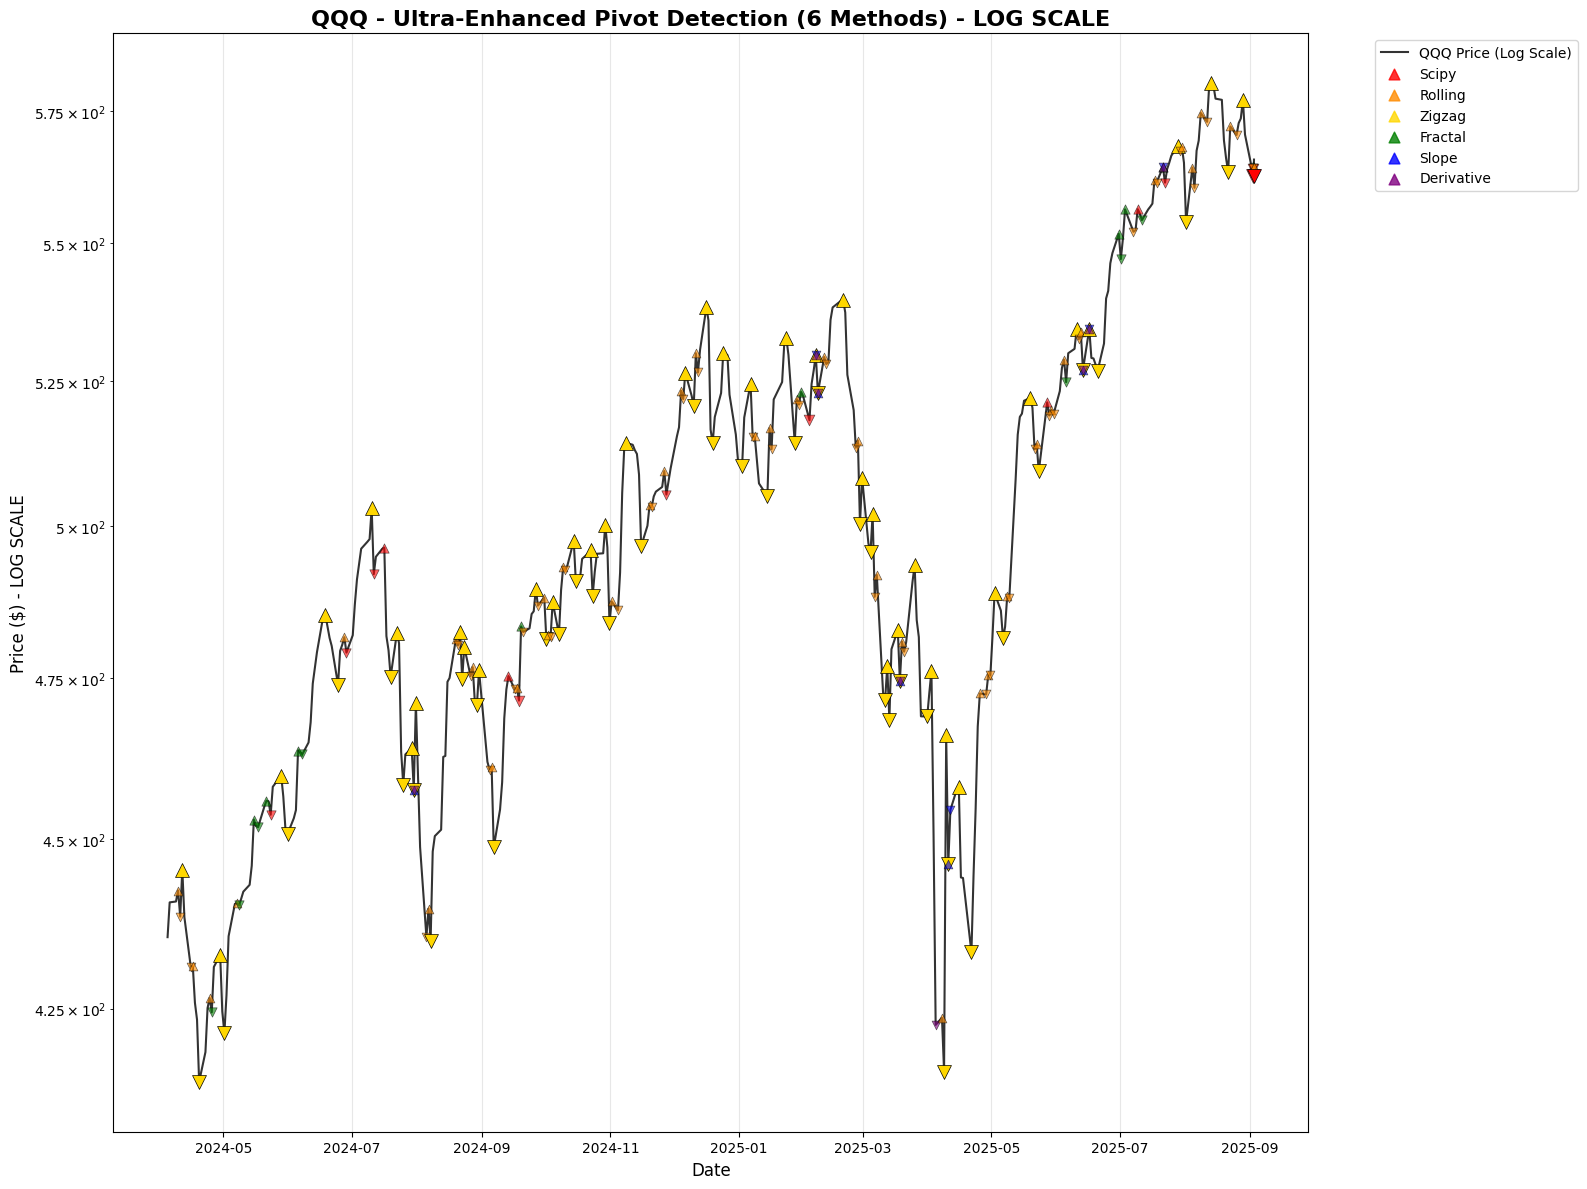

📊 Ultra-Enhanced LOG SCALE Pivot Points Summary:
   Total pivots: 202
   Swing highs: 101
   Swing lows: 101
   Method breakdown: {'rolling': 78, 'zigzag': 77, 'fractal': 16, 'scipy': 14, 'slope': 9, 'derivative': 8}
   Pivot density: 55.3% of price points are pivots

📈 Most Recent 10 LOG SCALE Pivots:
   1: $577.08 (log: 6.3580) (high) - 2025-08-28 - zigzag_1.0pct
   2: $562.52 (log: 6.3324) (low) - 2025-09-02 - scipy_w7
   3: $564.36 (log: 6.3357) (high) - 2025-09-02 - fractal
   4: $563.97 (log: 6.3350) (low) - 2025-09-02 - rolling_w3
   5: $563.98 (log: 6.3350) (high) - 2025-09-02 - rolling_w3
   6: $563.90 (log: 6.3349) (low) - 2025-09-02 - scipy_w4
   7: $564.00 (log: 6.3351) (high) - 2025-09-02 - rolling_w3
   8: $563.98 (log: 6.3350) (low) - 2025-09-02 - rolling_w3
   9: $564.17 (log: 6.3354) (high) - 2025-09-02 - rolling_w3
   10: $562.43 (log: 6.3323) (low) - 2025-09-02 - scipy_w15


In [18]:
# Step 2: Ultra-enhanced pivot point detection on LOG SCALE (fixed date handling)
def detect_pivot_points_ultra_log(data, methods=['scipy', 'rolling', 'zigzag', 'fractal', 'slope', 'derivative'], combine=True):
    """Ultra-enhanced pivot detection with comprehensive methods ON LOG SCALE"""
    log_prices = data['LogPrice'].values  # 🔬 USE LOG PRICES INSTEAD OF REGULAR PRICES
    regular_prices = data['Price'].values  # Keep regular prices for display
    dates = data['Date'].values

    all_pivots = []

    print(f"🔍 Ultra-enhanced LOG SCALE pivot detection using methods: {methods}")
    print(f"   📈 Working with log prices: {log_prices.min():.4f} to {log_prices.max():.4f}")

    # Method 1: Scipy with multiple window sizes ON LOG SCALE
    if 'scipy' in methods:
        print("   📊 Method 1: Scipy argrelextrema with multiple windows (LOG SCALE)")
        for window in [2, 3, 4, 5, 7, 10, 15]:  # Even more window sizes including very small ones
            swing_highs = argrelextrema(log_prices, np.greater, order=window)[0]
            swing_lows = argrelextrema(log_prices, np.less, order=window)[0]

            for idx in swing_highs:
                all_pivots.append({
                    'date': pd.to_datetime(dates[idx]),  # Ensure datetime object
                    'price': regular_prices[idx],        # Store regular price for display
                    'log_price': log_prices[idx],        # Store log price for calculations
                    'type': 'high',
                    'index': idx,
                    'method': f'scipy_w{window}',
                    'strength': window
                })

            for idx in swing_lows:
                all_pivots.append({
                    'date': pd.to_datetime(dates[idx]),  # Ensure datetime object
                    'price': regular_prices[idx],        # Store regular price for display
                    'log_price': log_prices[idx],        # Store log price for calculations
                    'type': 'low',
                    'index': idx,
                    'method': f'scipy_w{window}',
                    'strength': window
                })

        print(f"      Found {len([p for p in all_pivots if 'scipy' in p['method']])} scipy pivots")

    # Method 2: Rolling window extremes ON LOG SCALE
    if 'rolling' in methods:
        print("   📊 Method 2: Rolling window extremes (LOG SCALE)")
        for window in [3, 5, 7, 10, 15, 20]:
            df_temp = pd.DataFrame({'log_price': log_prices, 'price': regular_prices, 'index': range(len(log_prices))})

            rolling_max = df_temp['log_price'].rolling(window=window, center=True).max()
            rolling_min = df_temp['log_price'].rolling(window=window, center=True).min()

            highs = df_temp[(df_temp['log_price'] == rolling_max)]['index'].values
            lows = df_temp[(df_temp['log_price'] == rolling_min)]['index'].values

            for idx in highs:
                if 0 < idx < len(log_prices) - 1:
                    all_pivots.append({
                        'date': pd.to_datetime(dates[idx]),  # Ensure datetime object
                        'price': regular_prices[idx],        # Store regular price for display
                        'log_price': log_prices[idx],        # Store log price for calculations
                        'type': 'high',
                        'index': idx,
                        'method': f'rolling_w{window}',
                        'strength': window / 3
                    })

            for idx in lows:
                if 0 < idx < len(log_prices) - 1:
                    all_pivots.append({
                        'date': pd.to_datetime(dates[idx]),  # Ensure datetime object
                        'price': regular_prices[idx],        # Store regular price for display
                        'log_price': log_prices[idx],        # Store log price for calculations
                        'type': 'low',
                        'index': idx,
                        'method': f'rolling_w{window}',
                        'strength': window / 3
                    })

        print(f"      Found {len([p for p in all_pivots if 'rolling' in p['method']])} rolling pivots")

    # Method 3: ZigZag with multiple thresholds ON LOG SCALE
    if 'zigzag' in methods:
        print("   📊 Method 3: ZigZag percentage-based detection (LOG SCALE)")
        for threshold in [0.01, 0.015, 0.02, 0.03, 0.05, 0.08]:  # Even smaller thresholds
            zigzag_pivots = detect_zigzag_pivots_log(log_prices, regular_prices, dates, threshold)
            for pivot in zigzag_pivots:
                pivot['method'] = f'zigzag_{threshold*100:.1f}pct'
                pivot['strength'] = 1 / threshold
                pivot['date'] = pd.to_datetime(pivot['date'])  # Ensure datetime object
                all_pivots.append(pivot)

        print(f"      Found {len([p for p in all_pivots if 'zigzag' in p['method']])} zigzag pivots")

    # Method 4: Fractal-based detection ON LOG SCALE
    if 'fractal' in methods:
        print("   📊 Method 4: Fractal pattern detection (LOG SCALE)")
        fractal_pivots = detect_fractal_pivots_log(log_prices, regular_prices, dates)
        for pivot in fractal_pivots:
            pivot['method'] = 'fractal'
            pivot['strength'] = 3
            pivot['date'] = pd.to_datetime(pivot['date'])  # Ensure datetime object
            all_pivots.append(pivot)

        print(f"      Found {len([p for p in all_pivots if 'fractal' in p['method']])} fractal pivots")

    # Method 5: Slope change detection ON LOG SCALE
    if 'slope' in methods:
        print("   📊 Method 5: Slope change detection (LOG SCALE)")
        slope_pivots = detect_slope_change_pivots_log(log_prices, regular_prices, dates)
        for pivot in slope_pivots:
            pivot['method'] = 'slope'
            pivot['strength'] = 2
            pivot['date'] = pd.to_datetime(pivot['date'])  # Ensure datetime object
            all_pivots.append(pivot)

        print(f"      Found {len([p for p in all_pivots if 'slope' in p['method']])} slope pivots")

    # Method 6: Derivative-based detection ON LOG SCALE
    if 'derivative' in methods:
        print("   📊 Method 6: Derivative-based detection (LOG SCALE)")
        derivative_pivots = detect_derivative_pivots_log(log_prices, regular_prices, dates)
        for pivot in derivative_pivots:
            pivot['method'] = 'derivative'
            pivot['strength'] = 1.5
            pivot['date'] = pd.to_datetime(pivot['date'])  # Ensure datetime object
            all_pivots.append(pivot)

        print(f"      Found {len([p for p in all_pivots if 'derivative' in p['method']])} derivative pivots")

    print(f"🔍 Total raw pivots found: {len(all_pivots)}")

    if combine and len(all_pivots) > 0:
        combined_pivots = combine_overlapping_pivots(all_pivots, proximity_threshold=3)  # Tighter proximity
        print(f"🔍 Combined to {len(combined_pivots)} unique pivots")
        return combined_pivots, get_indices_by_type(combined_pivots, 'high'), get_indices_by_type(combined_pivots, 'low')
    else:
        return all_pivots, get_indices_by_type(all_pivots, 'high'), get_indices_by_type(all_pivots, 'low')

def detect_fractal_pivots_log(log_prices, regular_prices, dates, lookback=2):
    """Detect fractal patterns (Williams Fractal) ON LOG SCALE"""
    pivots = []

    for i in range(lookback, len(log_prices) - lookback):
        # Check for fractal high (higher than surrounding points) ON LOG SCALE
        is_fractal_high = True
        for j in range(i - lookback, i + lookback + 1):
            if j != i and log_prices[j] >= log_prices[i]:
                is_fractal_high = False
                break

        if is_fractal_high:
            pivots.append({
                'date': dates[i],
                'price': regular_prices[i],
                'log_price': log_prices[i],
                'type': 'high',
                'index': i
            })

        # Check for fractal low (lower than surrounding points) ON LOG SCALE
        is_fractal_low = True
        for j in range(i - lookback, i + lookback + 1):
            if j != i and log_prices[j] <= log_prices[i]:
                is_fractal_low = False
                break

        if is_fractal_low:
            pivots.append({
                'date': dates[i],
                'price': regular_prices[i],
                'log_price': log_prices[i],
                'type': 'low',
                'index': i
            })

    return pivots

def detect_slope_change_pivots_log(log_prices, regular_prices, dates, window=3):
    """Detect pivots based on slope changes ON LOG SCALE"""
    pivots = []

    # Calculate slopes ON LOG SCALE
    slopes = []
    for i in range(len(log_prices) - window):
        slope = (log_prices[i + window] - log_prices[i]) / window
        slopes.append(slope)

    # Find slope changes
    for i in range(1, len(slopes) - 1):
        prev_slope = slopes[i - 1]
        curr_slope = slopes[i]
        next_slope = slopes[i + 1]

        # Detect slope change from positive to negative (potential high)
        if prev_slope > 0 and curr_slope < 0:
            pivot_idx = i + window // 2
            if 0 <= pivot_idx < len(log_prices):
                pivots.append({
                    'date': dates[pivot_idx],
                    'price': regular_prices[pivot_idx],
                    'log_price': log_prices[pivot_idx],
                    'type': 'high',
                    'index': pivot_idx
                })

        # Detect slope change from negative to positive (potential low)
        elif prev_slope < 0 and curr_slope > 0:
            pivot_idx = i + window // 2
            if 0 <= pivot_idx < len(log_prices):
                pivots.append({
                    'date': dates[pivot_idx],
                    'price': regular_prices[pivot_idx],
                    'log_price': log_prices[pivot_idx],
                    'type': 'low',
                    'index': pivot_idx
                })

    return pivots

def detect_derivative_pivots_log(log_prices, regular_prices, dates):
    """Detect pivots using first and second derivatives ON LOG SCALE"""
    pivots = []

    # Calculate first derivative (gradient) ON LOG SCALE
    first_deriv = np.gradient(log_prices)

    # Calculate second derivative ON LOG SCALE
    second_deriv = np.gradient(first_deriv)

    for i in range(1, len(log_prices) - 1):
        # Look for sign changes in first derivative
        if first_deriv[i-1] > 0 and first_deriv[i+1] < 0:  # Peak
            pivots.append({
                'date': dates[i],
                'price': regular_prices[i],
                'log_price': log_prices[i],
                'type': 'high',
                'index': i
            })
        elif first_deriv[i-1] < 0 and first_deriv[i+1] > 0:  # Trough
            pivots.append({
                'date': dates[i],
                'price': regular_prices[i],
                'log_price': log_prices[i],
                'type': 'low',
                'index': i
            })

        # Also look for significant second derivative changes (inflection points)
        if abs(second_deriv[i]) > np.std(second_deriv) * 2:  # Significant curvature change
            if second_deriv[i] < 0:  # Concave down (potential high)
                pivots.append({
                    'date': dates[i],
                    'price': regular_prices[i],
                    'log_price': log_prices[i],
                    'type': 'high',
                    'index': i
                })
            elif second_deriv[i] > 0:  # Concave up (potential low)
                pivots.append({
                    'date': dates[i],
                    'price': regular_prices[i],
                    'log_price': log_prices[i],
                    'type': 'low',
                    'index': i
                })

    return pivots

def detect_zigzag_pivots_log(log_prices, regular_prices, dates, threshold=0.05):
    """ZigZag-style pivot detection based on percentage moves ON LOG SCALE"""
    pivots = []

    if len(log_prices) < 3:
        return pivots

    last_pivot_idx = 0
    last_pivot_log_price = log_prices[0]
    direction = None

    for i in range(1, len(log_prices)):
        log_price = log_prices[i]
        # Calculate percentage change using log difference (more accurate for percentage changes)
        pct_change = log_price - last_pivot_log_price  # Log difference = percentage change

        if direction is None:
            if pct_change > np.log(1 + threshold):  # Convert threshold to log space
                direction = 'up'
            elif pct_change < np.log(1 - threshold):
                direction = 'down'

        elif direction == 'up':
            if pct_change < np.log(1 - threshold):
                pivots.append({
                    'date': dates[last_pivot_idx],
                    'price': regular_prices[last_pivot_idx],
                    'log_price': log_prices[last_pivot_idx],
                    'type': 'high',
                    'index': last_pivot_idx
                })
                direction = 'down'
                last_pivot_idx = i
                last_pivot_log_price = log_price
            elif log_price > last_pivot_log_price:
                last_pivot_idx = i
                last_pivot_log_price = log_price

        elif direction == 'down':
            if pct_change > np.log(1 + threshold):
                pivots.append({
                    'date': dates[last_pivot_idx],
                    'price': regular_prices[last_pivot_idx],
                    'log_price': log_prices[last_pivot_idx],
                    'type': 'low',
                    'index': last_pivot_idx
                })
                direction = 'up'
                last_pivot_idx = i
                last_pivot_log_price = log_price
            elif log_price < last_pivot_log_price:
                last_pivot_idx = i
                last_pivot_log_price = log_price

    return pivots

def combine_overlapping_pivots(all_pivots, proximity_threshold=3):
    """Combine pivots that are close to each other with improved logic"""
    if not all_pivots:
        return []

    # Sort by index
    all_pivots.sort(key=lambda x: x['index'])

    combined = []
    i = 0

    while i < len(all_pivots):
        current_pivot = all_pivots[i]
        group = [current_pivot]

        # Look ahead for similar pivots
        j = i + 1
        while j < len(all_pivots):
            next_pivot = all_pivots[j]

            # Same type and within proximity
            if (next_pivot['type'] == current_pivot['type'] and
                abs(next_pivot['index'] - current_pivot['index']) <= proximity_threshold):
                group.append(next_pivot)
                j += 1
            else:
                break

        # Choose the best pivot from the group based on LOG PRICES
        if len(group) == 1:
            combined.append(group[0])
        else:
            # For highs, take the highest LOG price; for lows, take the lowest LOG price
            if current_pivot['type'] == 'high':
                best_pivot = max(group, key=lambda x: x['log_price'])
            else:
                best_pivot = min(group, key=lambda x: x['log_price'])

            # If multiple have same log price, take the one with highest strength
            same_price_group = [p for p in group if abs(p['log_price'] - best_pivot['log_price']) < 1e-6]
            if len(same_price_group) > 1:
                best_pivot = max(same_price_group, key=lambda x: x.get('strength', 1))

            combined.append(best_pivot)

        i = j

    return combined

def get_indices_by_type(pivots, pivot_type):
    """Extract indices for a specific pivot type"""
    return np.array([p['index'] for p in pivots if p['type'] == pivot_type])

def safe_date_format(date_obj):
    """Safely format date object to string"""
    if hasattr(date_obj, 'strftime'):
        return date_obj.strftime('%Y-%m-%d')
    else:
        # Handle numpy datetime64 or other formats
        return pd.to_datetime(date_obj).strftime('%Y-%m-%d')

# Ultra-enhanced detection ON LOG SCALE
pivots, swing_highs, swing_lows = detect_pivot_points_ultra_log(stock_data)

# Enhanced visualization with LOG SCALE and better colors
plt.figure(figsize=(16, 12))

# 🔬 PLOT WITH LOG SCALE ON Y-AXIS
plt.semilogy(stock_data['Date'], stock_data['Price'], 'k-', alpha=0.8, linewidth=1.5, label=f'{SYMBOL} Price (Log Scale)')

# Updated color map for better visibility on white background
method_colors = {
    'scipy': 'red',
    'rolling': 'darkorange',
    'zigzag': 'gold',
    'fractal': 'green',
    'slope': 'blue',
    'derivative': 'purple'
}

# Plot pivots with different colors and sizes based on method and strength
for pivot in pivots:
    method_type = pivot['method'].split('_')[0]
    color = method_colors.get(method_type, 'black')

    marker = '^' if pivot['type'] == 'high' else 'v'
    strength = pivot.get('strength', 1)
    size = max(40, min(100, strength * 15))  # Size based on strength
    alpha = max(0.6, min(1.0, strength / 10))

    plt.scatter([pivot['date']], [pivot['price']],
               color=color, marker=marker, s=size, alpha=alpha,
               edgecolors='black', linewidths=0.5, zorder=5)

# Create comprehensive legend
legend_elements = []
for method, color in method_colors.items():
    legend_elements.append(plt.scatter([], [], color=color, marker='^', s=60,
                                     label=f'{method.title()}', alpha=0.8))

plt.title(f'{SYMBOL} - Ultra-Enhanced Pivot Detection (6 Methods) - LOG SCALE', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($) - LOG SCALE', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Ultra-Enhanced LOG SCALE Pivot Points Summary:")
print(f"   Total pivots: {len(pivots)}")
print(f"   Swing highs: {len(swing_highs)}")
print(f"   Swing lows: {len(swing_lows)}")

# Method breakdown
method_breakdown = {}
for pivot in pivots:
    method = pivot['method'].split('_')[0]
    method_breakdown[method] = method_breakdown.get(method, 0) + 1

print(f"   Method breakdown: {method_breakdown}")

# Show density of detection
if len(stock_data) > 0:
    pivot_density = len(pivots) / len(stock_data) * 100
    print(f"   Pivot density: {pivot_density:.1f}% of price points are pivots")

# Show recent pivots for validation (with safe date formatting)
recent_pivots = sorted([p for p in pivots], key=lambda x: x['date'])[-10:]
print(f"\n📈 Most Recent 10 LOG SCALE Pivots:")
for i, pivot in enumerate(recent_pivots):
    date_str = safe_date_format(pivot['date'])
    print(f"   {i+1}: ${pivot['price']:.2f} (log: {pivot['log_price']:.4f}) ({pivot['type']}) - {date_str} - {pivot['method']}")

In [ ]:
# Step 3: Detect powerful LOG SCALE trendlines through iterative best-fit refinement
def find_iterative_trendline_log(pivot1, pivot2, all_pivots, tolerance_percent=2.0):  # 🔧 USE PERCENTAGE
    """
    Iteratively refine trendline using LOG SCALE by:
    1. Start with 2 points
    2. Find best-fit line using LOG PRICES
    3. Find other points within tolerance
    4. Add them and recalculate best-fit line
    5. Repeat until no new points found within tolerance
    """
    # Start with the initial two points
    current_points = [pivot1, pivot2]

    # Convert to numerical format for calculations using LOG SCALE
    def points_to_xy_log(points):
        x_vals = [(p['date'] - stock_data['Date'].iloc[0]).days for p in points]
        y_vals = [p['log_price'] for p in points]  # 🔬 USE LOG PRICES for trendline fitting
        return x_vals, y_vals

    # 🔧 CONVERT PERCENTAGE TO LOG TOLERANCE
    log_tolerance = np.log(1 + tolerance_percent/100)  # Convert 2% to proper log tolerance

    max_iterations = 100  # Allow more iterations for better fitting
    iteration = 0

    while iteration < max_iterations:
        iteration += 1

        # Calculate current best-fit line using LOG PRICES
        x_vals, y_vals = points_to_xy_log(current_points)

        if len(x_vals) < 2:
            break

        # Use scipy.stats.linregress for best-fit line on LOG SCALE
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)

        # Find additional points within tolerance of this best-fit line
        new_points = []
        for pivot in all_pivots:
            # Skip if already in current_points
            if pivot in current_points:
                continue

            x_pivot = (pivot['date'] - stock_data['Date'].iloc[0]).days
            expected_log_y = slope * x_pivot + intercept  # Expected LOG price
            actual_log_y = pivot['log_price']             # Actual LOG price

            # 🔧 PROPER LOG TOLERANCE: Convert percentage tolerance to log space
            log_difference = abs(expected_log_y - actual_log_y)
            if log_difference <= log_tolerance:  # Proper percentage tolerance in log space
                new_points.append(pivot)

        # If no new points found, we're done
        if not new_points:
            break

        # Add new points and continue iteration
        current_points.extend(new_points)

    # Final calculation with all points using LOG SCALE
    if len(current_points) >= 2:
        x_vals, y_vals = points_to_xy_log(current_points)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
        r_squared = r_value ** 2

        # Calculate percentage growth rate from log slope
        daily_growth_rate = (np.exp(slope) - 1) * 100  # Convert log slope to percentage growth per day

        return {
            'connected_points': current_points,
            'strength': len(current_points),
            'log_slope': slope,          # Log slope for calculations
            'log_intercept': intercept,  # Log intercept for calculations
            'daily_growth_rate': daily_growth_rate,  # Percentage growth rate per day
            'r_squared': r_squared,
            'iterations': iteration
        }
    else:
        return None

def detect_powerful_trendlines_log(pivots, max_lines=30):
    """Find powerful LOG SCALE trendlines using iterative best-fit refinement with smart pair removal"""
    trendlines = []
    used_trendline_pairs = set()  # 🔧 Track pairs that are BOTH in the same trendline

    print(f"🔍 LOG SCALE iterative trendline detection with proper 2% tolerance...")

    # Create list of all possible pairs first
    all_pairs = []
    for i, pivot1 in enumerate(pivots):
        for j, pivot2 in enumerate(pivots[i+1:], i+1):
            # 🔧 REMOVED TIME CONSTRAINT - no minimum time separation required
            all_pairs.append((i, j, pivot1, pivot2))

    print(f"   Created {len(all_pairs)} potential trendline pairs (no time constraints)")

    # Sort pairs by time distance to prefer longer trendlines first
    all_pairs.sort(key=lambda x: abs((x[3]['date'] - x[2]['date']).days), reverse=True)

    processed_pairs = 0
    skipped_pairs = 0

    for i, j, pivot1, pivot2 in all_pairs:
        processed_pairs += 1

        # 🔧 SMART PAIR REMOVAL: Skip only if BOTH points are in the same existing trendline
        pair_key = tuple(sorted([i, j]))
        if pair_key in used_trendline_pairs:
            skipped_pairs += 1
            continue

        # Find iterative trendline starting with this pair using LOG SCALE
        result = find_iterative_trendline_log(pivot1, pivot2, pivots, tolerance_percent=2.0)  # 2% proper tolerance

        if result and result['strength'] >= 2:  # Must connect at least 2 points
            trendline = {
                'start_pivot': pivot1,
                'end_pivot': pivot2,
                'connected_points': result['connected_points'],
                'strength': result['strength'],
                'log_slope': result['log_slope'],           # Store log slope
                'log_intercept': result['log_intercept'],   # Store log intercept
                'daily_growth_rate': result['daily_growth_rate'],  # Percentage growth per day
                'r_squared': result['r_squared'],
                'iterations': result['iterations'],
                'length_days': abs((pivot2['date'] - pivot1['date']).days)
            }

            trendlines.append(trendline)

            # 🔧 SMART PAIR REMOVAL: Only remove pairs where BOTH points are in this trendline
            connected_indices = []
            for point in result['connected_points']:
                try:
                    idx = next(idx for idx, p in enumerate(pivots) if p == point)
                    connected_indices.append(idx)
                except StopIteration:
                    continue

            # Remove pairs that use ANY TWO points from this trendline's connected points
            new_removed_pairs = 0
            for pi in range(len(connected_indices)):
                for pj in range(pi + 1, len(connected_indices)):
                    pair_to_remove = tuple(sorted([connected_indices[pi], connected_indices[pj]]))
                    if pair_to_remove not in used_trendline_pairs:
                        used_trendline_pairs.add(pair_to_remove)
                        new_removed_pairs += 1

            if len(trendlines) <= 10:  # Only show details for first 10
                print(f"   Found LOG trendline #{len(trendlines)}: {result['strength']} points, R²={result['r_squared']:.3f}, growth={result['daily_growth_rate']:.4f}%/day, {result['iterations']} iterations")
                print(f"      Removed {new_removed_pairs} internal pairs from future searches")

            # Stop if we have enough trendlines
            if len(trendlines) >= max_lines:
                break

    # Sort by strength and R-squared
    trendlines.sort(key=lambda x: (x['strength'], x['r_squared']), reverse=True)

    # Take top max_lines
    top_trendlines = trendlines[:max_lines]

    print(f"✅ Found {len(trendlines)} valid LOG SCALE trendlines using iterative refinement")
    print(f"   Processed {processed_pairs} pairs, skipped {skipped_pairs} internal pairs")
    print(f"   Final selection: {len(top_trendlines)} trendlines")

    if top_trendlines:
        strengths = [tl['strength'] for tl in top_trendlines]
        growth_rates = [tl['daily_growth_rate'] for tl in top_trendlines]
        iterations = [tl['iterations'] for tl in top_trendlines]

        print(f"   Strength range: {min(strengths)} - {max(strengths)} connected points")
        print(f"   Average strength: {np.mean(strengths):.1f} connected points")
        print(f"   Growth rate range: {min(growth_rates):.4f}% - {max(growth_rates):.4f}% per day")
        print(f"   Average growth rate: {np.mean(growth_rates):.4f}% per day")
        print(f"   Average iterations: {np.mean(iterations):.1f}")

    return top_trendlines

# For backwards compatibility, keep the old function signature
def calculate_trendline_strength_log(pivot1, pivot2, all_pivots, tolerance_percent=2.0):
    """Wrapper for backwards compatibility"""
    result = find_iterative_trendline_log(pivot1, pivot2, all_pivots, tolerance_percent)
    if result:
        return result['strength'], result['connected_points']
    else:
        return 0, []

powerful_trendlines = detect_powerful_trendlines_log(pivots, MAX_TRENDLINES)

# Display LOG SCALE trendline statistics
if powerful_trendlines:
    trendline_df = pd.DataFrame([
        {
            'Strength': tl['strength'],
            'R²': f"{tl['r_squared']:.3f}",
            'Growth %/day': f"{tl['daily_growth_rate']:.4f}%",
            'Log Slope': f"{tl['log_slope']:.6f}",
            'Iterations': tl['iterations'],
            'Length (days)': tl['length_days']
        } for tl in powerful_trendlines[:15]  # Show top 15
    ])
    print(f"\n📈 Top 15 LOG SCALE Iteratively Refined Trendlines (proper 2% tolerance, no time constraints):")
    print(trendline_df.to_string(index=False))

    print(f"\n🔬 LOG SCALE Trendline Interpretation:")
    print(f"   • Growth %/day: Daily percentage growth rate (compound interest)")
    print(f"   • Tolerance: 2% price deviation (properly converted to log space)")
    print(f"   • No time constraints: Any pivot separation allowed")
    print(f"   • Smart pair removal: Points can be reused in different trendlines")
else:
    print("⚠️ No powerful LOG SCALE trendlines found!")

🔍 LOG SCALE iterative trendline detection with proper 2% tolerance...
   Created 20301 potential trendline pairs (no time constraints)
   Found LOG trendline #1: 110 points, R²=0.972, growth=0.0483%/day, 6 iterations
      Removed 5995 internal pairs from future searches
   Found LOG trendline #2: 92 points, R²=0.975, growth=0.0504%/day, 13 iterations
      Removed 783 internal pairs from future searches
   Found LOG trendline #3: 41 points, R²=0.987, growth=0.0620%/day, 2 iterations
      Removed 442 internal pairs from future searches
   Found LOG trendline #4: 96 points, R²=0.976, growth=0.0538%/day, 9 iterations
      Removed 500 internal pairs from future searches
   Found LOG trendline #5: 37 points, R²=0.991, growth=0.0639%/day, 4 iterations
      Removed 122 internal pairs from future searches
   Found LOG trendline #6: 92 points, R²=0.979, growth=0.0497%/day, 6 iterations
      Removed 1050 internal pairs from future searches
   Found LOG trendline #7: 85 points, R²=0.962, gro

📊 LOG SCALE Trendline thickness mapping:
   Strength range: 5 - 110 points
   Thickness range: 1.0 - 5.0 pixels


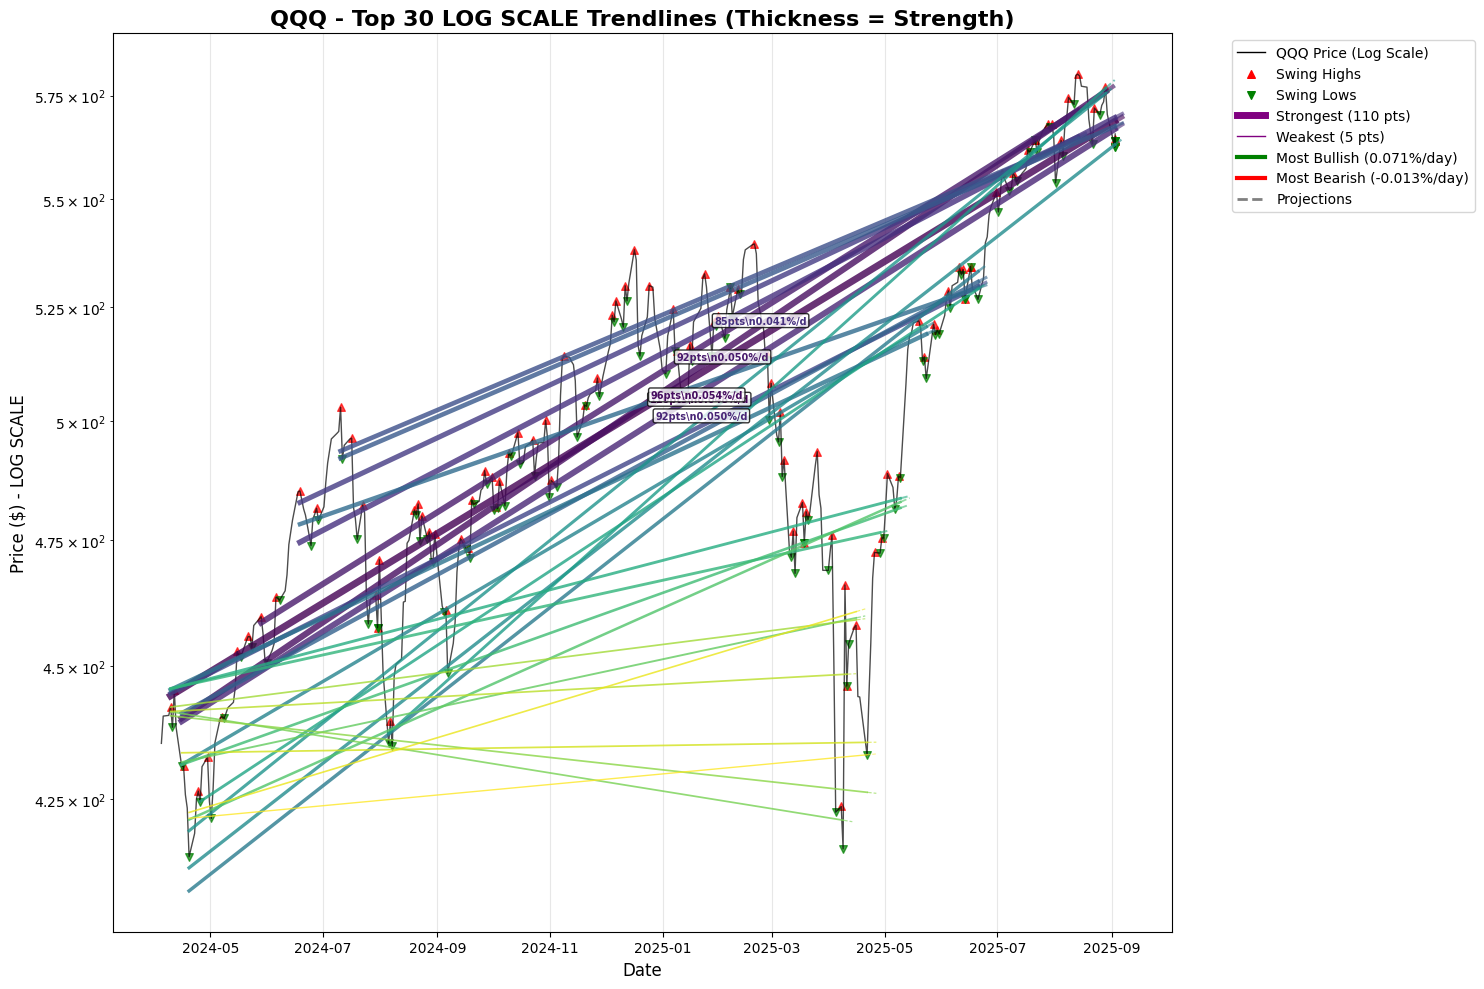


📊 LOG SCALE Trendline Strength & Growth Distribution:
   110 points: 1 lines (thickness: 5.0px, avg growth: 0.048%/day)
   96 points: 1 lines (thickness: 4.5px, avg growth: 0.054%/day)
   92 points: 2 lines (thickness: 4.3px, avg growth: 0.050%/day)
   85 points: 1 lines (thickness: 4.0px, avg growth: 0.041%/day)
   75 points: 1 lines (thickness: 3.7px, avg growth: 0.037%/day)
   66 points: 2 lines (thickness: 3.3px, avg growth: 0.037%/day)
   65 points: 1 lines (thickness: 3.3px, avg growth: 0.034%/day)
   62 points: 2 lines (thickness: 3.2px, avg growth: 0.035%/day)
   61 points: 1 lines (thickness: 3.1px, avg growth: 0.037%/day)
   44 points: 1 lines (thickness: 2.5px, avg growth: 0.062%/day)
   43 points: 1 lines (thickness: 2.4px, avg growth: 0.047%/day)
   41 points: 1 lines (thickness: 2.4px, avg growth: 0.062%/day)
   37 points: 1 lines (thickness: 2.2px, avg growth: 0.064%/day)
   33 points: 4 lines (thickness: 2.1px, avg growth: 0.040%/day)
   29 points: 1 lines (thickness: 

In [20]:
# Step 4: Visualize LOG SCALE trendlines with thickness based on strength
plt.figure(figsize=(15, 10))

# 🔬 PLOT WITH LOG SCALE ON Y-AXIS
plt.semilogy(stock_data['Date'], stock_data['Price'], 'k-', alpha=0.7, linewidth=1, label=f'{SYMBOL} Price (Log Scale)')

# Plot pivot points
plt.scatter(stock_data['Date'].iloc[swing_highs], stock_data['Price'].iloc[swing_highs],
           color='red', marker='^', s=30, alpha=0.7, label='Swing Highs')
plt.scatter(stock_data['Date'].iloc[swing_lows], stock_data['Price'].iloc[swing_lows],
           color='green', marker='v', s=30, alpha=0.7, label='Swing Lows')

# Plot LOG SCALE trendlines with thickness based on strength and different colors
if powerful_trendlines:
    # Calculate strength-based thickness
    strengths = [tl['strength'] for tl in powerful_trendlines]
    min_strength = min(strengths)
    max_strength = max(strengths)

    # Define thickness range (from 1 to 5 pixels)
    min_thickness = 1.0
    max_thickness = 5.0

    print(f"📊 LOG SCALE Trendline thickness mapping:")
    print(f"   Strength range: {min_strength} - {max_strength} points")
    print(f"   Thickness range: {min_thickness} - {max_thickness} pixels")

    colors = plt.cm.viridis(np.linspace(0, 1, len(powerful_trendlines)))

    for i, trendline in enumerate(powerful_trendlines):
        start_date = trendline['start_pivot']['date']
        end_date = trendline['end_pivot']['date']

        # Extend line for projection visualization
        extended_end_date = end_date + timedelta(days=PROJECTION_DAYS)

        # Calculate trendline values using LOG SCALE
        x1 = (start_date - stock_data['Date'].iloc[0]).days
        x2 = (extended_end_date - stock_data['Date'].iloc[0]).days

        # Calculate LOG values first, then convert to regular prices for plotting
        log_y1 = trendline['log_slope'] * x1 + trendline['log_intercept']
        log_y2 = trendline['log_slope'] * x2 + trendline['log_intercept']

        # Convert back to regular prices for plotting
        y1 = np.exp(log_y1)
        y2 = np.exp(log_y2)

        # Calculate thickness based on strength (relative to min/max)
        if max_strength > min_strength:
            strength_ratio = (trendline['strength'] - min_strength) / (max_strength - min_strength)
        else:
            strength_ratio = 1.0

        line_thickness = min_thickness + strength_ratio * (max_thickness - min_thickness)

        # Plot historical part with strength-based thickness
        hist_end_x = (end_date - stock_data['Date'].iloc[0]).days
        log_hist_end_y = trendline['log_slope'] * hist_end_x + trendline['log_intercept']
        hist_end_y = np.exp(log_hist_end_y)

        plt.plot([start_date, end_date],
                [y1, hist_end_y],
                color=colors[i], linewidth=line_thickness, alpha=0.8,
                label=f'Line {i+1} ({trendline["strength"]} pts, {trendline["daily_growth_rate"]:.3f}%/day)' if i < 5 else "")

        # Plot projection part (dashed) with same thickness
        plt.plot([end_date, extended_end_date],
                [hist_end_y, y2],
                color=colors[i], linewidth=line_thickness * 0.7, alpha=0.6, linestyle='--')

        # Add strength and growth rate annotation for top 5 strongest lines
        if i < 5:
            mid_date = start_date + (end_date - start_date) / 2
            mid_x = (mid_date - stock_data['Date'].iloc[0]).days
            log_mid_y = trendline['log_slope'] * mid_x + trendline['log_intercept']
            mid_y = np.exp(log_mid_y)

            # Create annotation text with both strength and growth rate
            annotation_text = f"{trendline['strength']}pts\\n{trendline['daily_growth_rate']:.3f}%/d"

            plt.annotate(annotation_text,
                        xy=(mid_date, mid_y),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=7, fontweight='bold', color=colors[i],
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

    plt.title(f'{SYMBOL} - Top {len(powerful_trendlines)} LOG SCALE Trendlines (Thickness = Strength)',
              fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($) - LOG SCALE', fontsize=12)

    # Create custom legend showing thickness meaning and growth rates
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], color='black', lw=1, label=f'{SYMBOL} Price (Log Scale)'))
    legend_elements.append(plt.scatter([], [], color='red', marker='^', s=30, label='Swing Highs'))
    legend_elements.append(plt.scatter([], [], color='green', marker='v', s=30, label='Swing Lows'))

    # Add thickness and growth rate examples to legend
    if len(powerful_trendlines) > 0:
        strongest = max(powerful_trendlines, key=lambda x: x['strength'])
        weakest = min(powerful_trendlines, key=lambda x: x['strength'])

        # Find most bullish and bearish trendlines
        most_bullish = max(powerful_trendlines, key=lambda x: x['daily_growth_rate'])
        most_bearish = min(powerful_trendlines, key=lambda x: x['daily_growth_rate'])

        legend_elements.append(plt.Line2D([0], [0], color='purple', lw=max_thickness,
                                        label=f'Strongest ({strongest["strength"]} pts)'))
        legend_elements.append(plt.Line2D([0], [0], color='purple', lw=min_thickness,
                                        label=f'Weakest ({weakest["strength"]} pts)'))
        legend_elements.append(plt.Line2D([0], [0], color='green', lw=3,
                                        label=f'Most Bullish ({most_bullish["daily_growth_rate"]:.3f}%/day)'))
        legend_elements.append(plt.Line2D([0], [0], color='red', lw=3,
                                        label=f'Most Bearish ({most_bearish["daily_growth_rate"]:.3f}%/day)'))
        legend_elements.append(plt.Line2D([0], [0], color='gray', lw=2, linestyle='--',
                                        label='Projections'))

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print LOG SCALE strength statistics
    print(f"\n📊 LOG SCALE Trendline Strength & Growth Distribution:")

    # Group by strength and show growth rates
    strength_growth = {}
    for tl in powerful_trendlines:
        strength = tl['strength']
        growth_rate = tl['daily_growth_rate']
        if strength not in strength_growth:
            strength_growth[strength] = []
        strength_growth[strength].append(growth_rate)

    for strength in sorted(strength_growth.keys(), reverse=True):
        growth_rates = strength_growth[strength]
        count = len(growth_rates)
        avg_growth = np.mean(growth_rates)
        thickness = min_thickness + ((strength - min_strength) / max(1, max_strength - min_strength)) * (max_thickness - min_thickness)
        print(f"   {strength} points: {count} lines (thickness: {thickness:.1f}px, avg growth: {avg_growth:.3f}%/day)")

    # Show growth rate statistics
    growth_rates = [tl['daily_growth_rate'] for tl in powerful_trendlines]
    print(f"\n📈 Growth Rate Analysis:")
    print(f"   Range: {min(growth_rates):.3f}% to {max(growth_rates):.3f}% per day")
    print(f"   Average: {np.mean(growth_rates):.3f}% per day")
    print(f"   Bullish lines (>0%): {len([g for g in growth_rates if g > 0])}")
    print(f"   Bearish lines (<0%): {len([g for g in growth_rates if g < 0])}")

    # Convert to annual rates for context
    annual_rates = [(np.exp(g/100 * 365) - 1) * 100 for g in growth_rates]
    print(f"\n📅 Annualized Growth Rates (compound):")
    print(f"   Range: {min(annual_rates):.1f}% to {max(annual_rates):.1f}% per year")
    print(f"   Average: {np.mean(annual_rates):.1f}% per year")

else:
    plt.title(f'{SYMBOL} - No Powerful LOG SCALE Trendlines Found', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($) - LOG SCALE', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"📊 LOG SCALE Visualization shows trendlines representing constant percentage growth rates")
if powerful_trendlines:
    print(f"   🔬 Each trendline represents exponential growth/decay at a constant percentage rate")
    print(f"   📈 Positive rates = compound growth, Negative rates = compound decay")
    print(f"   📊 Thickness proportional to strength (number of pivot points connected)")
    print(f"   🎯 Top 5 strongest lines annotated with strength and daily growth rate")

In [21]:
# Step 5: Save LOG SCALE trendlines data for use in trend cloud analysis
import pickle
import json
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

print(f"💾 Saving LOG SCALE trendline data for trend cloud analysis...")

try:
    # Save the LOG SCALE trendlines with all necessary data
    trendline_data = {
        'powerful_trendlines': powerful_trendlines,
        'stock_data': stock_data,
        'pivots': pivots,
        'symbol': SYMBOL,
        'projection_days': PROJECTION_DAYS,
        'temperature': TEMPERATURE,
        'log_scale': True,  # 🔬 FLAG TO INDICATE LOG SCALE DATA
        'analysis_type': 'log_scale'
    }

    # Save to pickle file
    with open('data/trendlines_data_log.pkl', 'wb') as f:
        pickle.dump(trendline_data, f)

    print(f"✅ Saved LOG SCALE trendline data to data/trendlines_data_log.pkl")
    print(f"   🎯 {len(powerful_trendlines)} powerful LOG SCALE trendlines")
    print(f"   📊 {len(stock_data)} stock data points with LogPrice column")
    print(f"   📍 {len(pivots)} LOG SCALE pivot points")
    print(f"   💹 Symbol: {SYMBOL}")
    print(f"   📅 Date range: {stock_data['Date'].min().date()} to {stock_data['Date'].max().date()}")
    print(f"   💰 Current price: ${stock_data['Price'].iloc[-1]:.2f} (log: {stock_data['LogPrice'].iloc[-1]:.4f})")

    # Also save as JSON for easier inspection
    json_data = {
        'symbol': SYMBOL,
        'projection_days': PROJECTION_DAYS,
        'temperature': TEMPERATURE,
        'current_price': float(stock_data['Price'].iloc[-1]),
        'current_log_price': float(stock_data['LogPrice'].iloc[-1]),
        'log_scale': True,
        'analysis_type': 'log_scale',
        'date_range': {
            'start': stock_data['Date'].min().strftime('%Y-%m-%d'),
            'end': stock_data['Date'].max().strftime('%Y-%m-%d')
        },
        'trendlines': []
    }

    for i, tl in enumerate(powerful_trendlines):
        json_data['trendlines'].append({
            'id': i,
            'strength': int(tl['strength']),
            'log_slope': float(tl['log_slope']),
            'log_intercept': float(tl['log_intercept']),
            'daily_growth_rate': float(tl['daily_growth_rate']),
            'annual_growth_rate': float((np.exp(tl['daily_growth_rate']/100 * 365) - 1) * 100),
            'r_squared': float(tl['r_squared']),
            'iterations': int(tl['iterations']),
            'length_days': int(tl['length_days']),
            'start_date': tl['start_pivot']['date'].strftime('%Y-%m-%d'),
            'start_price': float(tl['start_pivot']['price']),
            'start_log_price': float(tl['start_pivot']['log_price']),
            'end_date': tl['end_pivot']['date'].strftime('%Y-%m-%d'),
            'end_price': float(tl['end_pivot']['price']),
            'end_log_price': float(tl['end_pivot']['log_price'])
        })

    with open('data/trendlines_summary_log.json', 'w') as f:
        json.dump(json_data, f, indent=2)

    print(f"✅ Also saved LOG SCALE summary to data/trendlines_summary_log.json for inspection")

    strengths = [tl['strength'] for tl in powerful_trendlines]
    growth_rates = [tl['daily_growth_rate'] for tl in powerful_trendlines]
    annual_rates = [(np.exp(g/100 * 365) - 1) * 100 for g in growth_rates]

    print(f"\n📋 LOG SCALE Quick summary:")
    print(f"   Strength range: {min(strengths)} - {max(strengths)} points")
    print(f"   Average strength: {sum(strengths)/len(strengths):.1f} points")
    print(f"   Growth rate range: {min(growth_rates):.3f}% - {max(growth_rates):.3f}% per day")
    print(f"   Annual growth range: {min(annual_rates):.1f}% - {max(annual_rates):.1f}% per year")
    print(f"   📈 Bullish trendlines: {len([g for g in growth_rates if g > 0])}")
    print(f"   📉 Bearish trendlines: {len([g for g in growth_rates if g < 0])}")
    print(f"   Ready to load in LOG SCALE trend cloud analysis notebook!")

except Exception as e:
    print(f"❌ Error saving LOG SCALE trendlines: {e}")
    print("Make sure you have run the previous cells to generate the data")

# Show first few LOG SCALE trendlines as preview
print(f"\n🔍 Preview of saved LOG SCALE trendlines:")
for i, tl in enumerate(powerful_trendlines[:5]):
    annual_growth = (np.exp(tl['daily_growth_rate']/100 * 365) - 1) * 100
    print(f"   TL{i+1}: {tl['strength']} points, growth={tl['daily_growth_rate']:.4f}%/day ({annual_growth:.1f}%/year), R²={tl['r_squared']:.3f}")
    print(f"        {tl['start_pivot']['date'].strftime('%Y-%m-%d')} ${tl['start_pivot']['price']:.2f} → {tl['end_pivot']['date'].strftime('%Y-%m-%d')} ${tl['end_pivot']['price']:.2f}")

print(f"\n🔬 LOG SCALE Analysis Complete!")
print(f"   📈 Trendlines now represent constant percentage growth rates")
print(f"   💹 Better suited for exponential price movements")
print(f"   🎯 More meaningful for long-term trend analysis")

💾 Saving LOG SCALE trendline data for trend cloud analysis...
✅ Saved LOG SCALE trendline data to data/trendlines_data_log.pkl
   🎯 30 powerful LOG SCALE trendlines
   📊 365 stock data points with LogPrice column
   📍 202 LOG SCALE pivot points
   💹 Symbol: QQQ
   📅 Date range: 2024-04-04 to 2025-09-02
   💰 Current price: $565.62 (log: 6.3379)
✅ Also saved LOG SCALE summary to data/trendlines_summary_log.json for inspection

📋 LOG SCALE Quick summary:
   Strength range: 5 - 110 points
   Average strength: 45.8 points
   Growth rate range: -0.013% - 0.071% per day
   Annual growth range: -4.6% - 29.8% per year
   📈 Bullish trendlines: 28
   📉 Bearish trendlines: 2
   Ready to load in LOG SCALE trend cloud analysis notebook!

🔍 Preview of saved LOG SCALE trendlines:
   TL1: 110 points, growth=0.0483%/day (19.3%/year), R²=0.972
        2024-04-09 $442.23 → 2025-09-02 $562.52
   TL2: 96 points, growth=0.0538%/day (21.7%/year), R²=0.976
        2024-04-15 $431.06 → 2025-08-28 $577.08
   TL3